    ~“As far as the laws of mathematics refer to reality, they are not certain; and as far as they are certain, they do not refer to reality.”~ Einstein

# Loan Pricing & Segmentation

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
sns.set_style('darkgrid')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

C:\Users\Firo Obeid\Anaconda3\envs\pyfinance\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [45]:
#Function to get my model train and test data after shutting down notebook later on
def fit_data():
    model_data = pd.read_csv('modeldata.csv')
    feature_importance = pd.read_csv('Feature_importance.csv')
    features = list(feature_importance['Variable'][feature_importance.Importance >0].values)
    target = 'loan_status'
    X = model_data.drop(target, axis = 1)
    Y = model_data[target]
    X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state= 0)
    # Feature Scaling
    X_new = model_data[features]
    Y_new = model_data[target]
    X_train_select,X_test_select,y_train_select,y_test_select=train_test_split(X_new,Y_new,test_size=0.3,random_state= 0)
    scaler = MinMaxScaler()
    scaler.fit(X_train_select)
    scaled_train = scaler.transform(X_train_select) #ONLY FIT to train data!!
    scaled_test = scaler.transform(X_test_select)
    return X,Y,X_new,Y_new,X_train,X_test,y_train,y_test,scaled_train, scaled_test, y_train_select,y_test_select,features

In [5]:
X,Y,X_new,Y_new,X_train,X_test,y_train,y_test,scaled_train, scaled_test, y_train_select,y_test_select,features = fit_data()

# Load Models for Deployment
* GradientBoostingModel
* Neural Network Model
* Tuned Logestic Regression Model 

In [6]:
GBM_model = joblib.load('GBM.pkl')

In [7]:
GBM_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=20,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.0001,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [8]:
from keras.models import load_model
classifier_model = load_model('Loan_default_classifier_model.h5')
classifier_model.summary()

Using TensorFlow backend.


Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_547 (Dense)            (None, 5)                 420       
_________________________________________________________________
dense_548 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_549 (Dense)            (None, 1)                 6         
Total params: 456
Trainable params: 456
Non-trainable params: 0
_________________________________________________________________


In [9]:
logmodel_scaled = joblib.load('LR_scaled.pkl')

In [10]:
logmodel_scaled

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
scaler_model = joblib.load('scaler.pkl')
scaler_model

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
logmodel_scaled.predict_proba(scaled_test)

array([[3.47774005e-05, 9.99965223e-01],
       [1.82291252e-01, 8.17708748e-01],
       [1.32182144e-01, 8.67817856e-01],
       ...,
       [2.67407138e-01, 7.32592862e-01],
       [4.53048624e-01, 5.46951376e-01],
       [1.05544266e-01, 8.94455734e-01]])

In [13]:
classifier_model.predict_proba(scaled_test)

array([[0.9964893 ],
       [0.87370086],
       [0.8399008 ],
       ...,
       [0.9553135 ],
       [0.7395748 ],
       [0.9763949 ]], dtype=float32)

In [14]:
GBM_model.predict_proba(X_test)

array([[6.25547479e-05, 9.99937445e-01],
       [1.66440348e-02, 9.83355965e-01],
       [1.03808676e-01, 8.96191324e-01],
       ...,
       [1.79089122e-02, 9.82091088e-01],
       [1.93103213e-01, 8.06896787e-01],
       [7.90649572e-04, 9.99209350e-01]])

## Segmentation & Pricing
1. So far you have built three models: Logistic, Neural Network, and Gradient Boosting. Use each model to do segmentation; i.e. sort customers based on the probability of default estimated by each model, then classify them into 10 equal groups. Calculate bad rate for each group. Do your models Rank Order? Choose model with the best rank ordering for the next parts.

2. Assume risk free rate is 2%. Also assume that bad rate calculated in part 1, gives 1-year probability of default for each customer. Calculate the proper interest rate for each segment such that expected 1-year payoff for each segment equals 1-year risk-free pay off.

3. For the sake of simplicity assume that installments are paid annually; so for example a loan with 36 months term, will have 3 payments. Write a function that gets loan amount, number of payments, and interest rate as inputs, and calculates payments (look at this link for example:  https://financeformulas.net/Loan_Payment_Formula.html). Use this function to calculate annual payment for each loan where interest rate comes from part 2. For the loan amount use "loan_amount" field and for the term use "term" field.

4. Write a function that gets loan amount, probability of default, loan term, loan installment, and discount rate as inputs, and calculates the expected NPV of loan. Use this function to calculate expected NPV for each loan. For Probability of Default, use outputs of your scoring model. For loan installment use results of part 3. For discount rate use risk free rate.

Hint: Note that cash flows are stochastic. For example if probability of default for a customer is 10%, with 10% probability he/she will default at the end of the first year, hence zero payoff. With 90% bank will collect the first year installment, and will continue to second year. In the second year, again with 10% probability customer will default, and with 90% no default. Therefore probability that bank collects second year installment is 0.9*0.9 = 0.81. Continue until loan maturity.

5. Calculate total expected NPV for each segment. Plot total Expected NPV versus Bad Rate. What is your expectation about the shape of the curve?

### Segmentation 

In [15]:
def score_new(X,Y,model,clas):
    score = pd.DataFrame(1-model.predict_proba(X)[:,clas], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['Y'] = Y
    new_score = score.groupby('DECILE')['Y'].apply(lambda y : len([elem for elem in y if elem == 0 ])/len(y))
    # 0:Default
    return(new_score,score)

In [17]:
GBM_scoring,_ = score_new(X,Y,GBM_model,1)
GBM_scoring

DECILE
1.0     0.920257
2.0     0.197886
3.0     0.065928
4.0     0.034512
5.0     0.019893
6.0     0.011683
7.0     0.005782
8.0     0.001115
9.0     0.000425
10.0    0.000310
Name: Y, dtype: float64

In [18]:
logmodel_scoring, scored_data = score_new(scaler_model.transform(X_new), Y_new, logmodel_scaled,1)
logmodel_scoring

DECILE
1.0     0.595809
2.0     0.234615
3.0     0.163374
4.0     0.116104
5.0     0.076541
6.0     0.045372
7.0     0.021529
8.0     0.003167
9.0     0.000637
10.0    0.000641
Name: Y, dtype: float64

In [19]:
NN_scoring,_ = score_new(scaler_model.transform(X_new), Y_new, classifier_model,0)
NN_scoring

DECILE
1.0     0.758122
2.0     0.212674
3.0     0.125195
4.0     0.077690
5.0     0.044691
6.0     0.022799
7.0     0.010386
8.0     0.004384
9.0     0.001336
10.0    0.000513
Name: Y, dtype: float64

In [20]:
bad_rates = pd.concat([GBM_scoring,NN_scoring,logmodel_scoring],axis =1,keys = ['GBM', 'NN', 'LR'])
bad_rates

,GBM,NN,LR
DECILE,,,
1.0,0.920257,0.758122,0.595809
2.0,0.197886,0.212674,0.234615
3.0,0.065928,0.125195,0.163374
4.0,0.034512,0.077690,0.116104
5.0,0.019893,0.044691,0.076541
6.0,0.011683,0.022799,0.045372
7.0,0.005782,0.010386,0.021529
8.0,0.001115,0.004384,0.003167
9.0,0.000425,0.001336,0.000637


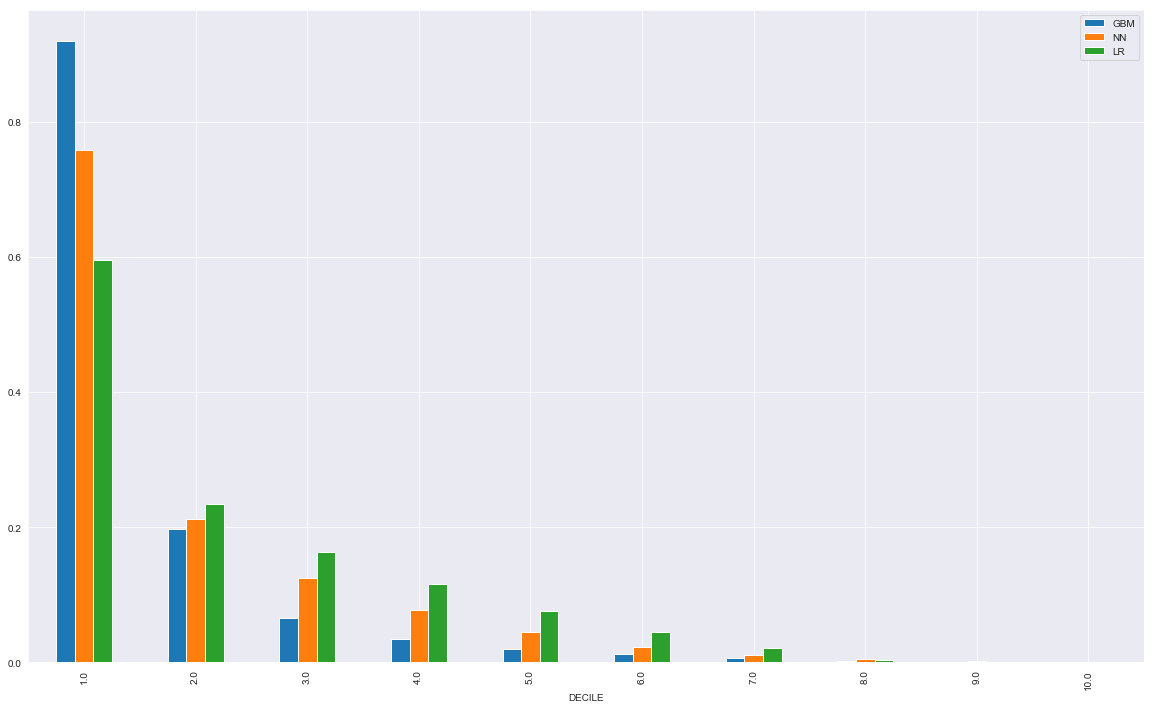

In [21]:
bad_rates.plot(kind='bar',figsize = (20,12));

### Pricing

In [22]:
bucket_int = bad_rates.LR.apply(lambda x: ((1.02)/(1-x))-1)
bucket_int

DECILE
1.0     1.523560
2.0     0.332663
3.0     0.219183
4.0     0.153982
5.0     0.104542
6.0     0.068479
7.0     0.042443
8.0     0.023241
9.0     0.020650
10.0    0.020655
Name: LR, dtype: float64

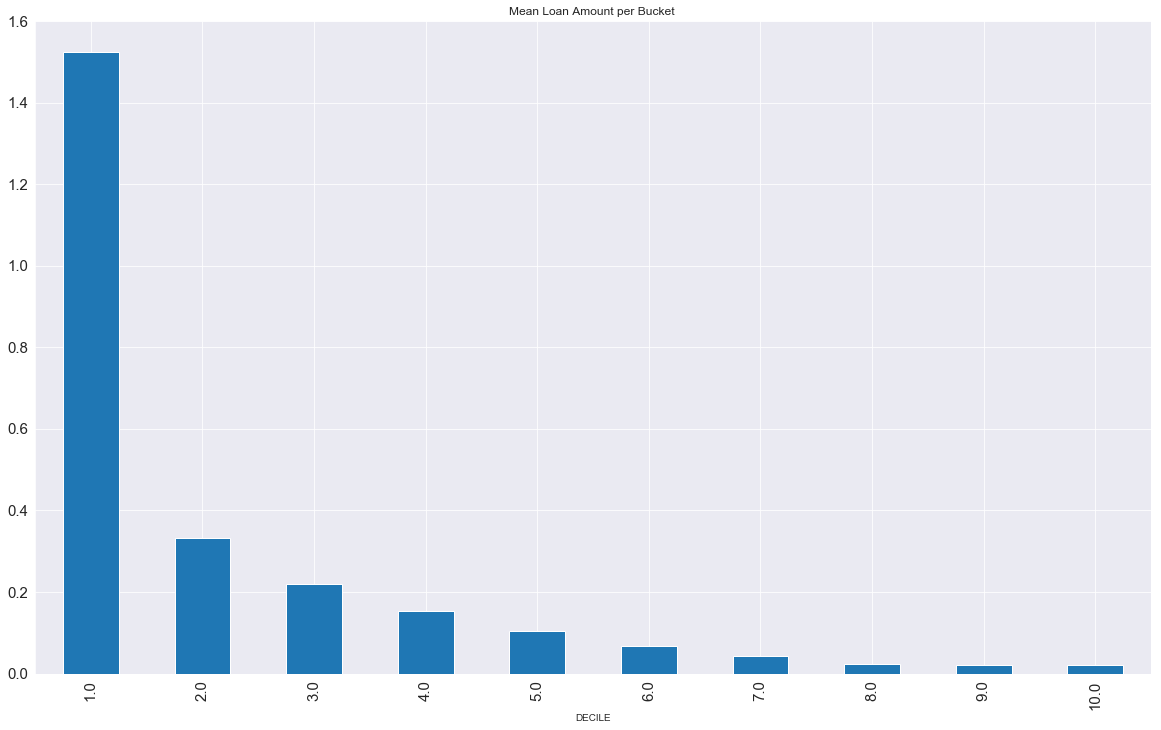

In [23]:
bucket_int.plot(kind='bar',figsize = (20,12), title = 'Mean Loan Amount per Bucket ', fontsize= 15);

In [24]:
interest = dict(bucket_int)
interest

{1.0: 1.5235603515261622,
 2.0: 0.33266260561996464,
 3.0: 0.21918289439594774,
 4.0: 0.153982293798826,
 5.0: 0.104542345276873,
 6.0: 0.06847915035193486,
 7.0: 0.04244307110855927,
 8.0: 0.023240854145588186,
 9.0: 0.02065014164305956,
 10.0: 0.020654659413329446}

In [25]:
scored_data['Interest'] = scored_data['DECILE'].map(interest)
scored_data['loan_amnt'] = X_new['loan_amnt']
scored_data['term_payments'] = X_new['term_ 60 months'].apply(lambda x: 5 if x == 1 else 3)

In [28]:
scored_data.tail(10)

,SCORE,DECILE,Y,Interest,loan_amnt,term_payments
2260629,5.891504e-09,10.0,1,0.020655,15000,5
2260630,1.216230e-01,4.0,1,0.153982,3500,3
2260631,1.273754e-01,4.0,1,0.153982,10000,3
2260632,6.375994e-01,1.0,1,1.523560,21000,5
2260633,4.864918e-01,1.0,1,1.523560,30000,5
2260634,1.333358e-01,3.0,1,0.219183,12000,5
2260635,1.960166e-02,7.0,1,0.042443,12000,5
2260636,6.371678e-02,5.0,1,0.104542,10000,3
2260637,1.331986e-01,3.0,1,0.219183,12000,5
2260638,1.192915e-01,4.0,1,0.153982,16550,5


DECILE
1.0     16649.114078
2.0     15226.767088
3.0     14313.384926
4.0     13406.860004
5.0     13461.285903
6.0     14285.587267
7.0     14466.852086
8.0     11484.206132
9.0     13668.622934
10.0    23508.054356
Name: loan_amnt, dtype: float64


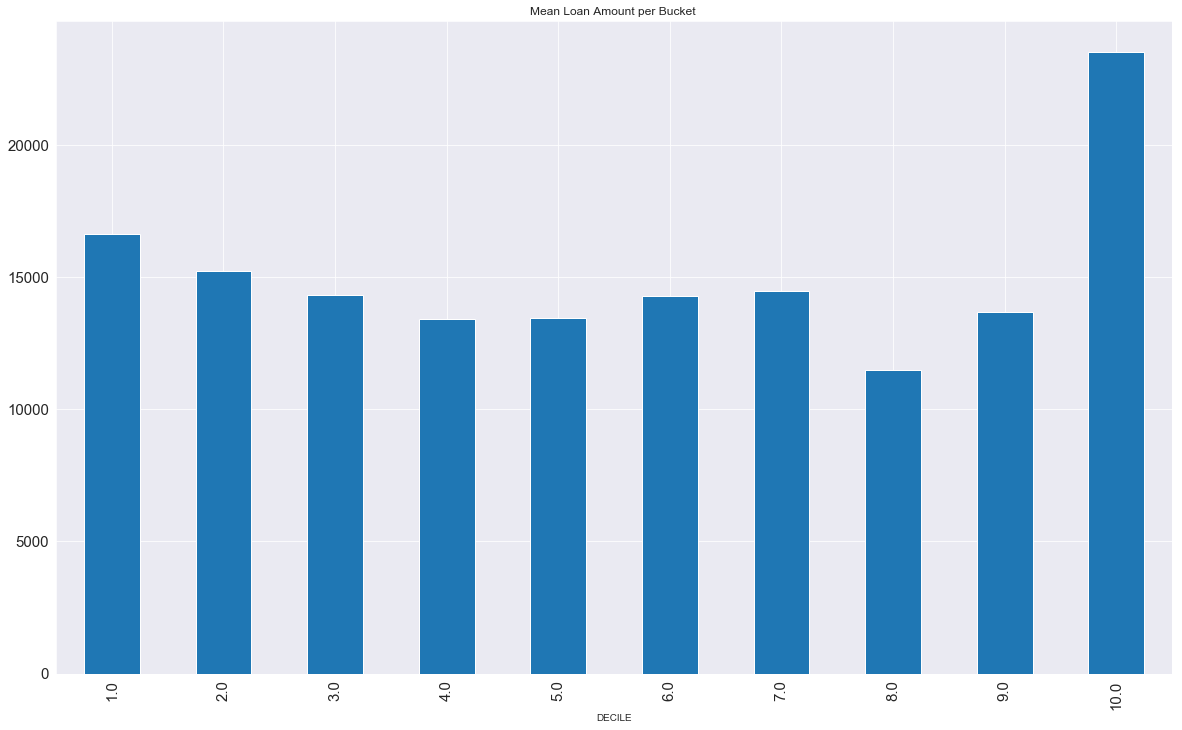

In [29]:
print(scored_data.groupby('DECILE')['loan_amnt'].mean())
scored_data.groupby('DECILE')['loan_amnt'].mean().plot(kind='bar',figsize = (20,12), title = 'Mean Loan Amount per Bucket ', fontsize= 15);

### Loan Payments Estimation

In [30]:
def calc_loan_pyts(r,PV,n):
    return r*PV/(1-(1+r)**-n)
    

In [31]:
scored_data['Payments'] = calc_loan_pyts(scored_data['Interest'], scored_data['loan_amnt'], scored_data['term_payments'])

In [32]:
scored_data.head(20)

,SCORE,DECILE,Y,Interest,loan_amnt,term_payments,Payments
0,0.110860,4.0,1,0.153982,2500,3,1102.180548
1,0.646451,1.0,1,1.523560,30000,5,46157.810736
2,0.145964,3.0,1,0.219183,5000,3,2445.227331
3,0.138035,3.0,1,0.219183,4000,3,1956.181865
4,0.345474,2.0,1,0.332663,30000,5,13095.276798
5,0.120074,4.0,1,0.153982,5550,3,2446.840817
6,0.134720,3.0,1,0.219183,2000,3,978.090932
7,0.026879,7.0,1,0.042443,6000,3,2172.123919
8,0.199146,3.0,1,0.219183,5000,3,2445.227331
9,0.120705,4.0,1,0.153982,6000,3,2645.233316


### Bucket Net Present Value 

In [33]:
def calculate_npv(x):
   rf_rate = 0.02
   disc_factor=(1-x["SCORE"])/(1+rf_rate)
   cashflows=[-x["loan_amnt"]]
   for i in range(1,int(x["term_payments"])+1):
       cashflows.append(x["Payments"]*(disc_factor**i))
       
   return np.sum(cashflows)


In [34]:
scored_data['NPV']=scored_data.apply(calculate_npv, axis=1)

In [39]:
scored_data.head(20)

,SCORE,DECILE,Y,Interest,loan_amnt,term_payments,Payments,NPV
0,0.110860,4.0,1,0.153982,2500,3,1102.180548,28.358216
1,0.646451,1.0,1,1.523560,30000,5,46157.810736,-5636.029109
2,0.145964,3.0,1,0.219183,5000,3,2445.227331,196.916737
3,0.138035,3.0,1,0.219183,4000,3,1956.181865,230.604199
4,0.345474,2.0,1,0.332663,30000,5,13095.276798,-9099.354265
5,0.120074,4.0,1,0.153982,5550,3,2446.840817,-47.351891
6,0.134720,3.0,1,0.219183,2000,3,978.090932,130.699742
7,0.026879,7.0,1,0.042443,6000,3,2172.123919,-64.471374
8,0.199146,3.0,1,0.219183,5000,3,2445.227331,-389.204221
9,0.120705,4.0,1,0.153982,6000,3,2645.233316,-59.296281


In [36]:
#Amother NPV calculator
def loan_NPV(r,proba_D,payments,loan_amnt, n): # A full mother function the calculate NPV, IRR and display pandas. All of that is done by passing the cashflows, period and rate of return(when needed)
    discount_factor = [] #The discounting factors will be stored in a list
    for h in range(0, n + 1): # loop to get discount factors and append to a list
        rate = (1 / ((1 + r) ** h))*((1-proba_D)**h)
        discount_factor.append(rate)
    npv_data = pd.DataFrame({'Cash_Flows': [i for i in range(0,n + 1)]}, index = [i for i in range(0, n + 1)]) #the iterations will take whatever cash flows assigned when my function is called in separate problems
    npv_data.index.name = 'Year' #The index is set to be named "Years'. The number of years is passed through function call
    npv_data.loc[0]['Cash_Flows'] = -loan_amnt #index zero in colmun with intial cost. The zero index was empty and reserved for the intial cost as stated
    npv_data.Cash_Flows.loc[[i for i in range(1, n + 1)]] = payments #tried several formats until this worked to change all cash flows through passing a list to the function and updating the iterable cash flow series. Note that range starts at 1 not 0 to keep 0 for intial cost reserved
    npv_data['Discounting factors'] = pd.Series(discount_factor) #panda columns are eventually series so I added a new series of the discounted cash flows through an outter function coded earlier
    npv_data['Discounted_Cash_Flows'] = npv_data.apply(np.prod, axis = 1) #apply method used to multiply cash flows column with discounting factors column to give new discounted cash flows column. Axis = 1 resembles columns and 0 for rows
#     npv = np.npv(r, npv_data.loc[:]['Cash_Flows']) #Pass cash flow column from dataframe. I could have summed up the discounted cash flows + intial cost, but kept a general frmat for calculation purposes
    npv= np.sum(npv_data.loc[:]['Discounted_Cash_Flows'])
    return npv # when calling the function I have to call all returned variables and fill all parameters. Some parameters are passed to allows the function to return a value without them yielding a significant implication on the functions calculations



In [37]:
loan_NPV(0.02,0.11086,1102.180548,2500,3)
# n=0
# for i in range(0,1000000):
#     scored_data['NPV'][i]= loan_NPV(0.02,scored_data['SCORE'][i], scored_data['Payments'][i], scored_data['loan_amnt'][i], scored_data['term_payments'][i])
#     n += 1
#     print("Loop number ", str(n))

28.359384836464983

In [40]:
#Save my final dataframe to file
scored_data.to_csv (r'C:\Users\Firo Obeid\Desktop\test\Scored_Data.csv', index = None, header=True)

#### Total Expected NPV per Bucket/Segment

In [43]:
Total_NPV = pd.DataFrame(scored_data.groupby('DECILE')['NPV'].sum())
Total_NPV

,NPV
DECILE,
1.0,-1.693394e+09
2.0,-6.962418e+08
3.0,-2.122870e+08
4.0,-3.775125e+07
5.0,-9.700866e+05
6.0,8.166442e+06
7.0,1.229999e+07
8.0,-3.918517e+06
9.0,1.368875e+06


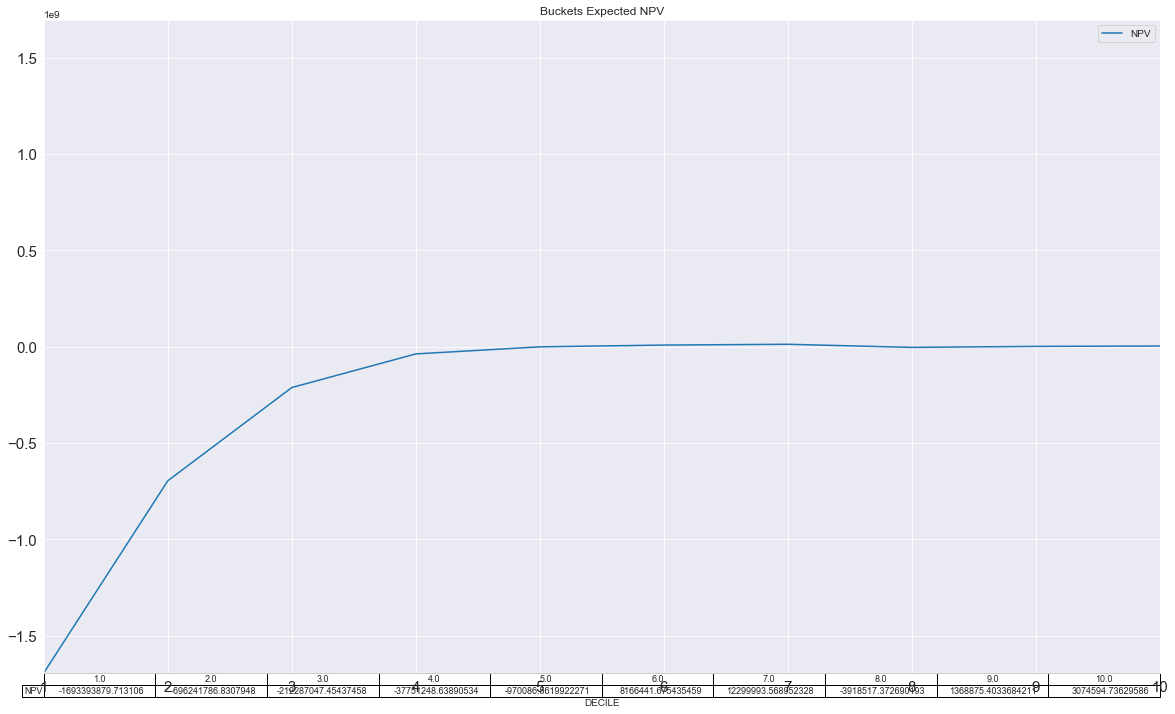

In [44]:
Total_NPV.plot(kind = 'line', ylim = (min(Total_NPV['NPV']),-min(Total_NPV['NPV'])), figsize = (20,12), title = 'Buckets Expected NPV', table = True, fontsize= 15);